<a href="https://colab.research.google.com/github/Coldvoltt/recommender_system/blob/main/movie_recomendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Recommender System - Content Based Filtering  Using The K-means Algorithm**

## **Introduction**
A content-based filtering approach for recommendation system is an advanced usage of artificial intelligence and machine learning that makes use of user preferences from the past as well as the intrinsic qualities of movies to offer tailored movie recommendations.  
A content-based filtering recommendation system, in contrast to collaborative filtering techniques, considers the major features of movies—such as genre, director, cast, storyline, and more—in order to propose movies that fit with a user's preferences.  
In addition to improving user experience by assisting users in finding fresh and pertinent content, this innovative algorithm provides insightful data to companies operating in the entertainment sector.






## **The Dataset**
The dataset used for this algorithm implemenatation is obtained at [GroupLens].(https://grouplens.org/datasets/movielens/) and the variables contained in the dataset are:  
1. User Id
2. Movie Id
3. Title
4. Rating
5. Genre

Details about the dataset can be obtained in the link provided.

## **Methodology**
- Data Ingestion.
- Data Preprocessing.
- Extra Preprocessing.
  - Sparsity Check and Handling.
- K-Means Algorithm.
  - Optimal Cluster Choice using WCSS.
  - Validating K cluster choice using Silhouette metric.
- Movie Recommendation based on user input.


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import requests
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

### Data Ingestion
The code chunks below are used to assess, download and extract the dataset from the link.

In [ ]:
# Define the URL of the ZIP file you want to download
zip_file_url = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'

# Define the directory where you want to extract the contents
extraction_path = '/content/movies_data'

# Create the target directory if it doesn't exist
if not os.path.exists(extraction_path):
    os.makedirs(extraction_path)


In [ ]:
# Download the ZIP file
response = requests.get(zip_file_url)
with open(os.path.join(extraction_path, 'downloaded.zip'), 'wb') as file:
    file.write(response.content)

# Extract the contents of the ZIP file
with zipfile.ZipFile(os.path.join(extraction_path, 'downloaded.zip'), 'r') as archive:
    archive.extractall(extraction_path)

# Clean up: remove the downloaded ZIP file
os.remove(os.path.join(extraction_path, 'downloaded.zip'))


Here we load the datasets as a pandas dataframe and view the dataframe structure

In [ ]:
# load movies and rating data
movies_data = pd.read_csv('movies_data/ml-latest-small/movies.csv')
ratings_data = pd.read_csv('movies_data/ml-latest-small/ratings.csv')

movies_data.head()


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
ratings_data.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### Data Preprocessing
The first step taken is to use an inner join for both datasets using `movieId` as the key. We observe the dataframe structure and we may observe that `genres` for some movie could contain more than one. We have an intention to make each genres be represented as a feature. The best approach would be to dummify the `genres` feature.

In [ ]:
# Feature Engineering
## merge both tables
movie_db = pd.merge(movies_data,
                    ratings_data,
                    on = 'movieId',
                    how = 'inner')

movie_db.tail()

,movieId,title,genres,userId,rating,timestamp
100831,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184,4.0,1537109082
100832,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184,3.5,1537109545
100833,193585,Flint (2017),Drama,184,3.5,1537109805
100834,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,184,3.5,1537110021
100835,193609,Andrew Dice Clay: Dice Rules (1991),Comedy,331,4.0,1537157606


Here, we convert genres into dummies, dropped the genre which is perceived to be problematic (`no genres listed`) We can see the result in the output below.  
User Id is also converted to dummys to make sure individuals are represented based on their watch history and ratings.

In [ ]:
# Consider Genres by converting into dummies
genre_dumies = movie_db['genres'].str.get_dummies('|')
genre_dumies.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Drop useless genre (No genres listed)
genre_dumies = genre_dumies.drop('(no genres listed)', axis = 1)

In [ ]:
# Join genre dummies with main df and drop genre column
movie_db_new = pd.concat([movie_db, genre_dumies], axis = 1).drop(['genres','timestamp'], axis = 1)
movie_db_new.head()

In [ ]:
movie_db_new.shape

#### Extra Preprocessing
We need to squeeze the dataframe by summarizing by `movieId`, using mean as the summary function. We also filter out movies with less than 10 ratings as that rating count may not be considered sufficient for movie recommendation.

In [ ]:
# Count occurence of ratings using movieId
ratings_count = movie_db_new['movieId'].value_counts()
# index movies appearing more than 10 times
valid_movie_ids = ratings_count[ratings_count >= 10].index
# Filter the DataFrame to exclude movie IDs that appear less than 10 times
movie_db_new = movie_db_new[movie_db_new['movieId'].isin(valid_movie_ids)]

In [ ]:
# Convert userId into dummy variables
movie_dbs = pd.get_dummies(movie_db_new, columns = ['userId'], prefix = 'User')
movie_dbs.columns

In [ ]:
movie_dbs.shape

(81116, 632)

#### Sparcity Check and Handling
With a dataframe containing lots of zeros and ones, having lots of features resulting from *dummyfication* operation, we are bound to have sparse data in our disposal and it is important we handle this situation.  
For every feature having more than a certain threshold of zeros (in our case, 99.5%), we drop the feature. Below is a function to implement it.

In [ ]:
# A function to reduce sparcity.

def drop_high_zero_columns(df, threshold=98.5):
    """
    Check for columns with more than a specified percentage of zeros and drop them from the DataFrame.
    Args:
        df (pd.DataFrame): The input DataFrame.
        threshold (int): The percentage threshold for dropping columns (default is 96).
    Returns:
        pd.DataFrame: The DataFrame with high-zero columns removed.
    """
    # Calculate the percentage of zeros in each column
    zero_percentage = (df == 0).mean() * 100

    # Check for columns with over the specified threshold of zeros
    columns_to_drop = zero_percentage[zero_percentage > threshold].index

    # Drop the identified columns
    df = df.drop(columns=columns_to_drop)

    return df

In [ ]:
# Call the function to drop high-zero columns
df = drop_high_zero_columns(movie_dbs, threshold=99.5)
df.shape

(81116, 65)

In [ ]:
df.columns

In [ ]:
# Check for unique movies
print(f'There are {len(df.movieId.unique())} movies in the db')

There are 2269 movies in the db


In [ ]:
# We make a dictionary to map movie ID and title
movie_id_title = dict(zip(df['movieId'], df['title']))

In [ ]:
# we drop the movie title.
df = df.drop(columns='title')

In [ ]:
df.head()

In [ ]:
# Group the DataFrame by 'movieId' and calculate the mean for each group
df = df.groupby('movieId').mean().reset_index()

# Drop movies with ratings less than 3.0/5.0
main_df = df[df['rating'] > 3]

In [ ]:
main_df.shape

(1828, 64)

## **K-Means Algorithm**
The k-means algorithm is a ML algorithm; a clustering method commonly used to generate labels or clusters in which items are grouped based on their similar characteristics.  
Here's a brief note on how the k-means algorithm is typically implemented in this system:


**Feature Extraction:** In the context of a content-based recommendation system for movies, relevant features or attributes are extracted from the movie dataset. These features can include genres, and other relevant information.  

**Feature Representation:** Each movie is represented as a feature vector in a multidimensional space, with each feature corresponding to a specific attribute.

**Choosing the Number of Clusters (K):** The first step is to determine the number of clusters (K) that the k-means algorithm will use. This number can be determined through techniques like the elbow method, where the optimal K is selected by analyzing the within-cluster sum of squares.  

**K-Means Clustering:** The k-means algorithm is applied to the feature vectors of movies. It iteratively assigns movies to the nearest cluster centroid (based on a distance metric like Euclidean distance) and updates the centroids. This process continues until convergence is reached or a predefined number of iterations is completed.

**Cluster Labels:** Once the clustering is complete, each movie is assigned to a specific cluster. This grouping helps identify movies that share similar content attributes.

**User Profiling:** User profiles are created based on their historical interactions, preferences, or explicit ratings. These profiles are also represented in the same feature space.

**Recommendation:** To make recommendations, the system identifies the cluster(s) that best represent a user's preferences based on their profile. It then suggests movies from the clusters most similar to the user's profile. These suggestions are content-based because they are derived from the features of the movies and the user's content-based preferences.

**Dynamic Updates:** The clustering can be periodically updated to accommodate new movies or changes in user preferences.  

By implementing the k-means algorithm in a content-based movie recommendation system, you can efficiently group movies with similar content attributes and provide personalized recommendations based on the content features that users have historically shown interest in.

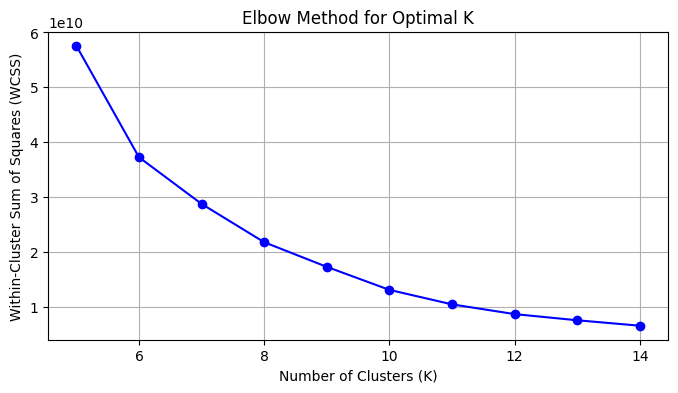

In [ ]:
## CLUSTERING

wcss = []
# Specify the range of K values to test
k_values = range(5, 15)  # You can adjust this range as needed

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(main_df)  # dataset
    wcss.append(kmeans.inertia_)  # WCSS for this K value

plt.figure(figsize=(8, 4))
plt.plot(k_values, wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid()
plt.show()



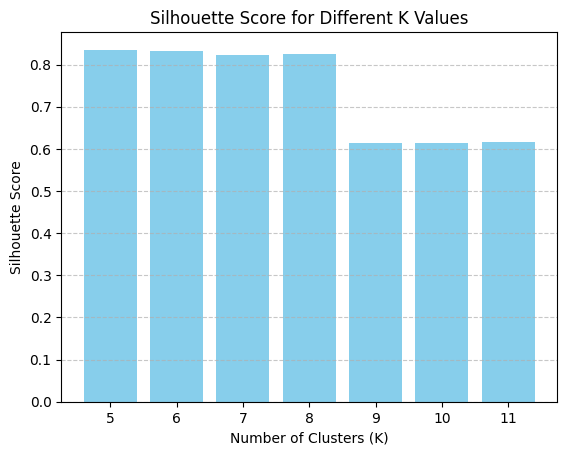

In [ ]:
from sklearn.metrics import silhouette_score

# Define the values of K you want to evaluate
k_values = range(5, 12)
silhouette_scores = []

for k in k_values:
    # Create a KMeans model with the current K value
    kmeans = KMeans(n_clusters=k, random_state=0)

    # Fit the model to your data
    kmeans.fit(main_df)

    # Get the cluster labels
    labels = kmeans.labels_

    # Calculate the silhouette score for this K value
    silhouette_avg = silhouette_score(main_df, labels)

    # Append the silhouette score to the list
    silhouette_scores.append(silhouette_avg)

# Create a bar plot to visualize silhouette scores
plt.bar(k_values, silhouette_scores, color='skyblue')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different K Values')
plt.xticks(k_values)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
# Choose the number of clusters (K)
K = 8

kmeans = KMeans(n_clusters=K)
labels = kmeans.fit_predict(main_df)

In [ ]:
# Add cluster labels to the DataFrame
main_df['cluster'] = labels

main_df['cluster'].unique()

array([0, 3, 7, 5, 1, 2, 4, 6], dtype=int32)

In [ ]:
# mapping movie title from the saved dictionary with the cluster df
main_df['title'] = main_df['movieId'].map(movie_id_title)

In [ ]:
main_df

In [ ]:
# Filter for movie title, cluster and rating
titles_clusters = main_df[['title', 'cluster', 'rating']]
titles_clusters

In [ ]:
titles_clusters[titles_clusters['cluster'] == 2].sort_values(by='rating', ascending=False)

In [ ]:

def recommender(movie_title, df=titles_clusters, n=10):
    # Convert movie titles to lowercase for case-insensitive matching
    movie_title = movie_title.lower()

    closest_title = None

    # Create an empty list to store matching titles
    matching_titles = []

    # Iterate through the DataFrame to find partial string matches
    for title in df['title']:
        if movie_title in title.lower():
            matching_titles.append(title)

    if not matching_titles:
        return "No matching movie title found in the dataset."

    # Select the closest matching title based on partial string match
    title = matching_titles[0]

    # Find the cluster of the closest matching movie title
    cluster = df[df['title'] == title]['cluster'].values[0]

    # Filter the DataFrame to include only movies from the same cluster
    cluster_movies = df[df['cluster'] == cluster]

    # Exclude the closest match from the recommendations
    cluster_movies = cluster_movies[cluster_movies['title'].str.lower() != title.lower()]

    # Sort the remaining movies by rating in descending order and get the top n
    top_movies = cluster_movies.sort_values(by='rating', ascending=False).head(n)

    # Get the titles of the top movies
    top_movie_titles = top_movies['title']

    result = (f"Movie title closest match is: {title}.", f"Top {n} recommendations are:", top_movie_titles)

    return result




### Something Unique
We have ensured that the user input flexibility extends to the extent that, if a user provides only a fragment of a movie's name, the system will intelligently identify the closest match and use this information to generate tailored movie recommendations in response.

In [ ]:
# We call the recommender function
recommender('Ultron')

('Movie title closest match is: Avengers: Age of Ultron (2015).',
 'Top 10 recommendations are:',
 2210                         Wild Tales (2014)
 2249                          Spotlight (2015)
 2230         Untitled Spider-Man Reboot (2017)
 2225                     Thor: Ragnarok (2017)
 2208                 The Imitation Game (2014)
 2224    Avengers: Infinity War - Part I (2018)
 2233                        The Martian (2015)
 2216       Kingsman: The Secret Service (2015)
 2226          Guardians of the Galaxy 2 (2017)
 2246                       The Revenant (2015)
 Name: title, dtype: object)